In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [56]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import io
import numpy as np

In [3]:
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
!rm F-F_Research_Data_Factors_CSV.zip

--2021-11-17 06:58:50--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.172.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.172.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12509 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.22K  --.-KB/s    in 0s      

2021-11-17 06:58:50 (210 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12509/12509]

Archive:  F-F_Research_Data_Factors_CSV.zip
  inflating: F-F_Research_Data_Factors.CSV  [binary]


In [4]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

In [5]:
from google.colab import files
myfile = files.upload()

Saving F-F_Research_Data_Factors.csv to F-F_Research_Data_Factors.csv


In [6]:
factor_df = pd.read_csv(io.BytesIO(myfile['F-F_Research_Data_Factors.csv']))
factor_df.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [7]:

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

factor_df = factor_df[factor_df.index < start_of_annual]
factor_df.head()

,192609,0.36,-1.32,0.01,0.23
0,192610,-3.24,0.04,0.51,0.32
1,192611,2.53,-0.20,-0.35,0.31
2,192612,2.62,-0.04,-0.02,0.28
3,192701,-0.06,-0.56,4.83,0.25
4,192702,4.18,-0.10,3.17,0.26


In [8]:
factor_df.columns=['date','mkt','smb','hml','rf']
factor_df['date']=pd.to_datetime(factor_df['date'],
                                 format='%Y%m')\
                                 .dt.strftime("%Y-%m")
factor_df=factor_df.set_index('date')
factor_df=factor_df.loc[START_DATE:END_DATE]

In [9]:
factor_df=factor_df.apply(pd.to_numeric,
                          errors='coerce')\
                          .div(100)


factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


In [10]:
asset_df=yf.download(RISKY_ASSET,start=START_DATE,end=END_DATE,adjusted=True)
y=asset_df['Adj Close'].resample('M')\
                        .last()\
                        .pct_change()\
                        .dropna()
y.index=y.index.strftime('%Y-%m')
y.name='rtn'

[*********************100%***********************]  1 of 1 completed


In [11]:
ff_data=factor_df.join(y)
ff_data['excess_rtn']=ff_data.rtn-ff_data.rf

In [12]:
ff_model=smf.ols(formula='excess_rtn~mkt+smb+hml',data=ff_data).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.175
Date:                Wed, 17 Nov 2021   Prob (F-statistic):            0.00316
Time:                        06:59:00   Log-Likelihood:                 88.392
No. Observations:                  60   AIC:                            -168.8
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.373      0.1

In [13]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [14]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [16]:
ff_dict=web.DataReader('F-F_Research_Data_Factors','famafrench',start='2014-01-01')
ff_dict

{0:          Mkt-RF   SMB   HML   RF
 Date                            
 2014-01   -3.32  0.92 -2.02  0.0
 2014-02    4.65  0.37 -0.31  0.0
 2014-03    0.43 -1.87  4.92  0.0
 2014-04   -0.19 -4.20  1.14  0.0
 2014-05    2.06 -1.89 -0.13  0.0
 ...         ...   ...   ...  ...
 2021-05    0.29 -0.28  7.04  0.0
 2021-06    2.75  1.80 -7.76  0.0
 2021-07    1.27 -3.96 -1.75  0.0
 2021-08    2.90 -0.48 -0.13  0.0
 2021-09   -4.37  0.80  5.09  0.0
 
 [93 rows x 4 columns], 1:       Mkt-RF    SMB    HML    RF
 Date                            
 2014   11.71  -7.81  -1.46  0.02
 2015    0.08  -3.92  -9.54  0.02
 2016   13.30   6.64  22.62  0.20
 2017   21.51  -4.95 -13.48  0.80
 2018   -6.93  -3.34  -9.80  1.81
 2019   28.28  -6.06 -10.48  2.14
 2020   23.67  12.77 -46.31  0.44, 'DESCR': 'F-F Research Data Factors\n-------------------------\n\nThis file was created by CMPT_ME_BEME_RETS using the 202109 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2021 K

In [17]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [18]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202109 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2021 Kenneth R. French

  0 : (93 rows x 4 cols)
  1 : Annual Factors: January-December (7 rows x 4 cols)


In [19]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.92,-2.02,0.0
2014-02,4.65,0.37,-0.31,0.0
2014-03,0.43,-1.87,4.92,0.0
2014-04,-0.19,-4.20,1.14,0.0
2014-05,2.06,-1.89,-0.13,0.0


In [20]:
ff_dict[1].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014,11.71,-7.81,-1.46,0.02
2015,0.08,-3.92,-9.54,0.02
2016,13.30,6.64,22.62,0.20
2017,21.51,-4.95,-13.48,0.80
2018,-6.93,-3.34,-9.80,1.81


In [24]:
asset_df1=yf.download('MSFT',start=START_DATE,end=END_DATE,adjusted=True)
y1=asset_df1['Adj Close'].resample('M')\
                          .last()\
                          .pct_change()\
                          .dropna()

y1.index=y1.index.strftime('%Y-%m')
y1.name='rtn'
print(y1)

[*********************100%***********************]  1 of 1 completed
Date
2014-01    0.011494
2014-02    0.020012
2014-03    0.069956
2014-04   -0.014394
2014-05    0.020515
2014-06    0.018564
2014-07    0.035012
2014-08    0.059169
2014-09    0.020471
2014-10    0.012727
2014-11    0.024740
2014-12   -0.028446
2015-01   -0.130247
2015-02    0.093120
2015-03   -0.072748
2015-04    0.196261
2015-05   -0.030334
2015-06   -0.057832
2015-07    0.057758
2015-08   -0.061949
2015-09    0.017004
2015-10    0.189336
2015-11    0.039444
2015-12    0.020791
2016-01   -0.007030
2016-02   -0.069789
2016-03    0.085495
2016-04   -0.097049
2016-05    0.070197
2016-06   -0.034528
2016-07    0.107680
2016-08    0.020080
2016-09    0.002437
2016-10    0.040278
2016-11    0.012468
2016-12    0.031198
2017-01    0.040393
2017-02   -0.004364
2017-03    0.029384
2017-04    0.039478
2017-05    0.026006
2017-06   -0.013030
2017-07    0.054693
2017-08    0.033953
2017-09   -0.003745
2017-10    0.116660
2017-1

In [25]:
ff_data1=ff_dict[0].join(y)
ff_data1['excess_rtn']=ff_data1.rtn-ff_data.rf

# **portfolio 3factor model**

In [51]:
Assets=['AMZN','GOOG','AAPL','MSFT','TSLA']
Weights=[0.2,0.2,0.2,0.2,0.2]
start_date='2009-12-31'
end_date='2018-12-31'

In [71]:
df_three_factor=web.DataReader('F-F_Research_Data_Factors','famafrench',start=start_date)[0]
df_three_factor=df_three_factor.div(100)
df_three_factor.index=df_three_factor.index.format()


In [72]:
portfolio=yf.download(Assets,start=start_date,end=end_date,adjusted=True,progress=False)


In [73]:
portfolio=portfolio['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
portfolio.index=portfolio.index.strftime('%Y-%m')

In [74]:
portfolio.head()

,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2010-07,0.022741,0.078986,0.089673,0.121686,-0.163240
2010-08,-0.055005,0.058868,-0.071837,-0.085812,-0.023069
2010-09,0.167215,0.258191,0.168370,0.043460,0.047741
2010-10,0.060723,0.052018,0.167196,0.089016,0.070064
2010-11,0.033790,0.061551,-0.094492,-0.047049,0.617674


In [75]:
portfolio['portfolio_rtn']=np.matmul(portfolio[Assets].values,Weights)
portfolio.head()

,AAPL,AMZN,GOOG,MSFT,TSLA,portfolio_rtn
Date,,,,,,
2010-07,0.022741,0.078986,0.089673,0.121686,-0.163240,0.029969
2010-08,-0.055005,0.058868,-0.071837,-0.085812,-0.023069,-0.035371
2010-09,0.167215,0.258191,0.168370,0.043460,0.047741,0.136996
2010-10,0.060723,0.052018,0.167196,0.089016,0.070064,0.087803
2010-11,0.033790,0.061551,-0.094492,-0.047049,0.617674,0.114295


In [76]:
ff_data2 = portfolio.join(df_three_factor).drop(Assets, axis=1)
ff_data2.head()

,portfolio_rtn,Mkt-RF,SMB,HML,RF
Date,,,,,
2010-07,0.029969,0.0693,0.0024,-0.0030,0.0001
2010-08,-0.035371,-0.0477,-0.0295,-0.0196,0.0001
2010-09,0.136996,0.0954,0.0396,-0.0317,0.0001
2010-10,0.087803,0.0388,0.0121,-0.0249,0.0001
2010-11,0.114295,0.0060,0.0377,-0.0088,0.0001


In [77]:
ff_data2.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data2['portf_ex_rtn'] = ff_data2.portf_rtn - ff_data2.rf
ff_data2.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-07,0.029969,0.0693,0.0024,-0.0030,0.0001,0.029869
2010-08,-0.035371,-0.0477,-0.0295,-0.0196,0.0001,-0.035471
2010-09,0.136996,0.0954,0.0396,-0.0317,0.0001,0.136896
2010-10,0.087803,0.0388,0.0121,-0.0249,0.0001,0.087703
2010-11,0.114295,0.0060,0.0377,-0.0088,0.0001,0.114195


In [84]:
def rolling_factor_model(input_data,formula,window_size):
    coeffs=[]
    for start_index in range(len(input_data)-window_size+1):
        end_index=start_index+window_size

        ff_model=smf.ols(formula=formula,data=input_data[start_index:end_index]).fit()
        coeffs.append(ff_model.params)



    coeffs_df=pd.DataFrame(coeffs,index=input_data.index[window_size-1:])

    return coeffs_df

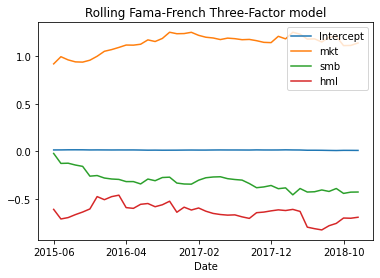

In [85]:
MODEL_FORMULA='portf_ex_rtn ~ mkt + smb + hml'
results_df=rolling_factor_model(ff_data2,MODEL_FORMULA,window_size=60)
results_df.plot(title='Rolling Fama-French Three-Factor model')